## Build your own, high-granurality features


In [1]:
import numpy as np

import scipy as sp
import scipy.ndimage as ndi
from scipy.signal import argrelextrema

import pandas as pd

from skimage import measure
from sklearn import metrics

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)

This part contains the already polished functionality.

In [1]:
# ----------------------------------------------------- I/O ---

def read_img(img_no):
    """reads image from disk"""
    return mpimg.imread('../input/images/' + str(img_no) + '.jpg')


def get_imgs(num):
    """convenience function, yields random sample from leaves"""
    if type(num) == int:
        imgs = range(1, 1584)
        num = np.random.choice(imgs, size=num, replace=False)
        
    for img_no in num:
        yield img_no, preprocess(read_img(img_no))


# ----------------------------------------------------- preprocessing ---

def threshold(img, threshold=250):
    """splits img to 0 and 255 values at threshold"""
    return ((img > threshold) * 255).astype(img.dtype)


def portrait(img):
    """makes all leaves stand straight"""
    y, x = np.shape(img)
    return img.transpose() if x > y else img
    

def resample(img, size):
    """resamples img to size without distorsion"""
    ratio = size / max(np.shape(img))
    return sp.misc.imresize(img, ratio, mode='L', interp='nearest')

    
def fill(img, size=500, tolerance=0.95):
    """extends the image if it is signifficantly smaller than size"""
    y, x = np.shape(img)

    if x <= size * tolerance:
        pad = np.zeros((y, int((size - x) / 2)), dtype=int)
        img = np.concatenate((pad, img, pad), axis=1)

    if y <= size * tolerance:
        pad = np.zeros((int((size - y) / 2), x), dtype=int)
        img = np.concatenate((pad, img, pad), axis=0) 
    
    return img


# ----------------------------------------------------- postprocessing ---

def standardize(arr1d):
    """move mean to zero, 1st SD to -1/+1"""
    return (arr1d - arr1d.mean()) / arr1d.std()


def coords_to_cols(coords):
    """from x,y pairs to feature columns"""
    return coords[::,1], coords[::,0]


def get_contour(img):
    """returns the coords of the longest contour"""
    return max(measure.find_contours(img, .8), key=len)


def get_center(img):
    """so that I do not have to remember the function ;)"""
    return ndi.measurements.center_of_mass(img)


# ----------------------------------------------------- feature engineering ---

def extract_shape(img):
    """
    Expects prepared image, returns leaf shape in img format.
    The strength of smoothing had to be dynamically set
    in order to get consistent results for different sizes.
    """
    size = int(np.count_nonzero(img)/1000)
    brush = int(5 * size/size**.75)
    return ndi.gaussian_filter(img, sigma=brush, mode='nearest') > 200


def near0_ix(timeseries_1d, radius=5):
    """finds near-zero values in time-series"""
    return np.where(timeseries_1d < radius)[0]


def dist_line_line(src_arr, tgt_arr):
    """
    returns 2 tgt_arr length arrays, 
    1st is distances, 2nd is src_arr indices
    """
    return np.array(sp.spatial.cKDTree(src_arr).query(tgt_arr))


def dist_line_point(src_arr, point):
    """returns 1d array with distances from point"""
    point1d = [[point[0], point[1]]] * len(src_arr)
    return metrics.pairwise.paired_distances(src_arr, point1d)


def index_diff(kdt_output_1):
    """
    Shows pairwise distance between all n and n+1 elements.
    Useful to see, how the dist_line_line maps the two lines.
    """
    return np.diff(kdt_output_1)


# ----------------------------------------------------- wrapping functions ---

# wrapper function for all preprocessing tasks    
def preprocess(img, do_portrait=True, do_resample=500, 
               do_fill=True, do_threshold=250):
    """ prepares image for processing"""
    if do_portrait:
        img = portrait(img)
    if do_resample:
        img = resample(img, size=do_resample)
    if do_fill:
        img = fill(img, size=do_resample)
    if do_threshold:
        img = threshold(img, threshold=do_threshold)
        
    return img

This is the exploratory part.

In [1]:
# exploring solution before building it as function

# img, shape
title, img = list(get_imgs([194]))[0]  #709
blur = extract_shape(img)

# img contour, shape contour  
blade = get_contour(img)
shape = get_contour(blur)

# matplotlib needs them in columnar format
blade_x, blade_y = coords_to_cols(blade)
shape_x, shape_y = coords_to_cols(shape)

# flagging blade points that fall inside the shape contour
blade_inv_ix = blur[blade_y.astype(int), blade_x.astype(int)]

# img distance, shape distance (for time series plotting)
shape_cy, shape_cx = get_center(blur)
blade_dist = dist_line_line(shape, blade)
shape_dist = dist_line_point(shape, [shape_cx, shape_cy])

# fixing false + signs in the blade time series
blade_dist[0, blade_inv_ix] = blade_dist[0, blade_inv_ix] * -1

# loading kaggle features
kaggle_shape = pd.read_csv('../input/train.csv').iloc[107,66:130]
kaggle_blade = pd.read_csv('../input/train.csv').iloc[107,2:66]

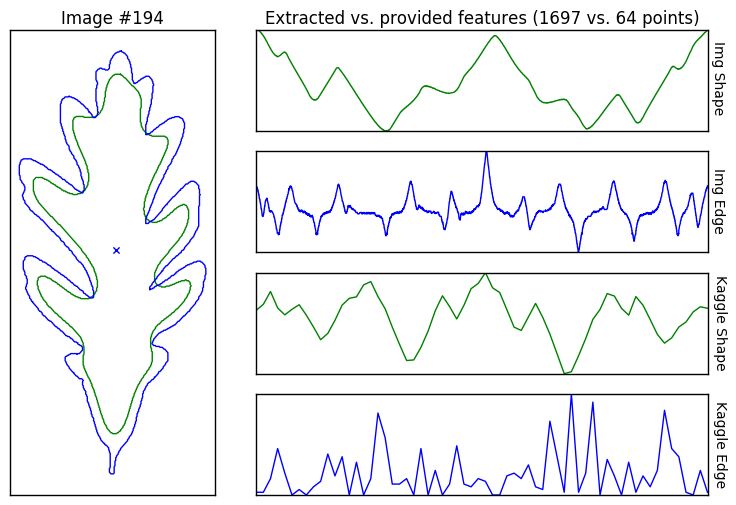

In [1]:
# visualization of the two set of features
rcParams['figure.figsize'] = (9,6)

ax1 = plt.subplot2grid((4,3), (0,0), rowspan=4)
ax1.set_title('Image #' + str(title))
ax1.set_xticks([])
ax1.set_yticks([])
ax1.plot(shape_x, shape_y, c='g')
ax1.plot(blade_x, blade_y, c='b')
ax1.scatter(shape_cx, shape_cy, marker='x')

ax2 = plt.subplot2grid((4,3), (0,1), colspan=2)
ax2.text(1710, 170, 'Img Shape', rotation=270)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Extracted vs. provided features ('+ 
              str(len(shape_dist)) +' vs. 64 points)')
ax2.plot(range(len(shape_dist)), shape_dist, c='g')

ax3 = plt.subplot2grid((4,3), (1,1), colspan=2)
ax3.text(2460, 30, 'Img Edge', rotation=270)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.plot(range(len(blade_dist[0])), blade_dist[0], c='b')

ax4 = plt.subplot2grid((4,3), (2,1), colspan=2)
ax4.text(63.7, .00032, 'Kaggle Shape', rotation=270)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.plot(range(len(kaggle_shape)), kaggle_shape, c='g')

ax5 = plt.subplot2grid((4,3), (3,1), colspan=2)
ax5.text(63.7, .06, 'Kaggle Edge', rotation=270)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.plot(range(len(kaggle_blade)), kaggle_blade, c='b')

plt.show()